# PyTIVA Tiny Tutorial
Last updated 30 April 2023

PyTIVA is Python Tools for Investigating and Visualizing Activity, built to parse and process anesthesia records and determine activity and staffing levels throughout a time period of interest.

In [1]:
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# these two lines will be unnecessary if pytiva is installed as a python package
import sys
sys.path.append("/home/tj/PycharmProjects/pytiva")

import pytiva

### Extracting from an Excel file
Data exports from electronic anesthesia records may be in a variety of file formats, but Microsoft Excel is a fairly common one.

PyTIVA has utilities to extract these as a batch process and set them aside in comma-separated values formats.

In [2]:
# working directory
wd = r'/home/tj/PycharmProjects/pytiva/data'

sheets = {
    'cases': {
        'SHEET_LABEL': 'Base',
        'CSV_FILENAME': 'cases'
    },
    'events': {
        'SHEET_LABEL': 'Events',
        'CSV_FILENAME': 'case_events'
    },
    'medications': {
        'SHEET_LABEL': 'Medications',
        'CSV_FILENAME': 'case_medications'
    }
}

filepaths_out = pytiva.utils.dump_csv_from_excel(
    os.path.join(wd, 'anesthesia_case_data_dump.xlsx'),
    wd,
    sheets,
    csv_prefix='202302050900-')
filepaths_out

['/home/tj/PycharmProjects/pytiva/data/202302050900-cases.csv',
 '/home/tj/PycharmProjects/pytiva/data/202302050900-case_events.csv',
 '/home/tj/PycharmProjects/pytiva/data/202302050900-case_medications.csv']

### Loading CSV files into a pytiva AnesthesiaStudy object
An AnesthesiaStudy object holds multiple DataSet objects and has methods for interacting with them. Column names, which were left alone in the Excel-->CSV step, can be updated at this step, and extra columns can be trimmed out.

(Each type of standardized anesthesia DataSet within pytiva expects particular columns in order to reliably produce functionality. For example, they all require a 'case_id' column, which is a unique identifier for the given admission in order to have the case data, medication data, and intra-operative event data all interact.)

In [3]:
wd = r'/home/tj/PycharmProjects/pytiva/tests/test_data'

csv_dict = {
    'ds_cases': {
        'FILEPATH': os.path.join(wd, 'testdata-ds_cases.csv')
    },
    'ds_case_meds': {
        'FILEPATH': os.path.join(wd, 'testdata-ds_case_meds.csv')
    },
    'ds_case_events': {
        'FILEPATH': os.path.join(wd, 'testdata-ds_case_events.csv')
    }
}

datasets = pytiva.anesthesia.datasets_from_csv_data(csv_dict)
study = pytiva.anesthesia.AnesthesiaStudy(**datasets)
study

### AnesthesiaStudy object ###
* Case data *
ds_cases['anesthesia_start'] range: 2021-09-22 20:14:30 to 2022-01-10 09:24:01
ds_cases (500 rows)
ds_case_events (8942 rows)
ds_case_meds (4313 rows)

### Setting up study parameters
An AnesthesiaStudy object has methods to limit the included cases by dates and procedures, as well as to generate anesthesia activity based on medication administration and intra-operative events. These can be called directly, or in a batch as a configuration dictionary.

In [4]:
STUDY_CONFIG = {
    'CASE_LIMITS': {
        'ANESTHESIA_START_RANGE': ('2021-10-01', '2021-10-31')
    },
    'ACTIVITIES': {
        'MEDICATION_ACTIVITY_OFFSET_BEFORE': pd.to_timedelta(2, unit='minute'),
        'MEDICATION_ACTIVITY_OFFSET_AFTER': pd.to_timedelta(3, unit='minute'),
        'EVENT_ACTIVITY_DEFINITIONS': [
            {
                "activity_label": "activity A",
                "start_event": "8e329bd8e26dcce3346b9717043bd7dbb897ebefe9efc",
                "end_event": "5ec0619e404ddedfc928bf84bab8d85b151"
            },
            {
                "activity_label": "activity B",
                "start_event": "7c68a0232e",
                "end_event": "17c59b70155f163ff22987a948c712d53d60e910e42d2b8011c96dba52c4",
                
                # optional bounds to truncate the maximium duration of this activity
                # in comparison to the raw distribution
                # for example, this will limit the duration to twice the 95%ile duration
                "max_duration_quantile": 0.95,
                "max_duration_factor": 2
            }
        ]
    }
}

study.process_study_config(STUDY_CONFIG)
study

### AnesthesiaStudy object ###
* Case data *
ds_cases['anesthesia_start'] range: 2021-10-02 07:02:20 to 2021-10-30 21:59:55
ds_cases (157 rows)
ds_case_events (2837 rows)
ds_case_meds (1325 rows)

* Activity data *
ds_activity: "medication" (1325 entries), "activity A" (126 entries), "activity B" (58 entries)

### Concurrent activity and visualization
AnesthesiaStudy objects also provide methods for unduplicating the anesthesia activity contained in the various DataSet objects. By default, these unduplicate at the level of a case_id, meaning they unduplicate the data such that the maximum activity per case id at one time is one. Effectively, each patient is reduced to at most one activity at each moment in time.

The AnesthesiaStudy.unduplicate_concurrency() method exposes this functionality most simply. Under the hood, it first unduplicates and then determines concurrency (total unduplicated activity) for each moment in time. The strata used for unduplication can be overwritten by providing a different collection to strata (default strata=['case_id']), and the resolution of the concurrent activity can be set by passing a parseable string to resolution for creating a TimeDelta object (default resolution='1min').

In [5]:
# resolution can be any valid time and unit, such as '15min', 'T', 'M', etc.
cc_ts = study.unduplicate_concurrency(strata=['case_id'], resolution='15min')
cc_ts = cc_ts.reindex(
    pd.date_range(
        start=cc_ts.index.min(),
        end=cc_ts.index.max() + pd.to_timedelta(1, unit='D') - pd.to_timedelta(1, unit='T'),
        freq='T'),
    method='ffill'
)
cc_ts

,concurrent_activity_count
2021-10-02 07:02:00,1.0
2021-10-02 07:03:00,1.0
2021-10-02 07:04:00,1.0
2021-10-02 07:05:00,1.0
2021-10-02 07:06:00,1.0
...,...
2021-11-01 01:57:00,1.0
2021-11-01 01:58:00,1.0
2021-11-01 01:59:00,1.0
2021-11-01 02:00:00,1.0


### Weekly concurrency
The concurrency time series can be fed into a concurrent_weekly_activity() helper function to aggregate things by day of the week.

In [6]:
cc_activity_wa = pytiva.activity.utils.concurrent_weekly_activity(cc_ts)
cc_activity_wa

day_name,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
minute_of_day,,,,,,,
0,1.2,1.0,0.5,0.50,0.25,0.75,0.5
1,1.2,1.0,0.5,0.50,0.25,0.75,0.5
2,1.2,0.8,0.5,0.75,0.25,0.75,0.5
3,1.2,0.8,0.5,0.75,0.25,0.75,0.5
4,1.2,0.8,0.5,0.75,0.25,0.75,0.5
...,...,...,...,...,...,...,...
1435,1.0,0.5,0.5,0.25,0.75,0.50,1.2
1436,1.0,0.5,0.5,0.25,0.75,0.50,1.2
1437,1.0,0.5,0.5,0.25,0.75,0.50,1.2


### Visualization
Take advantage of matplotlib and seaborn library functionality.

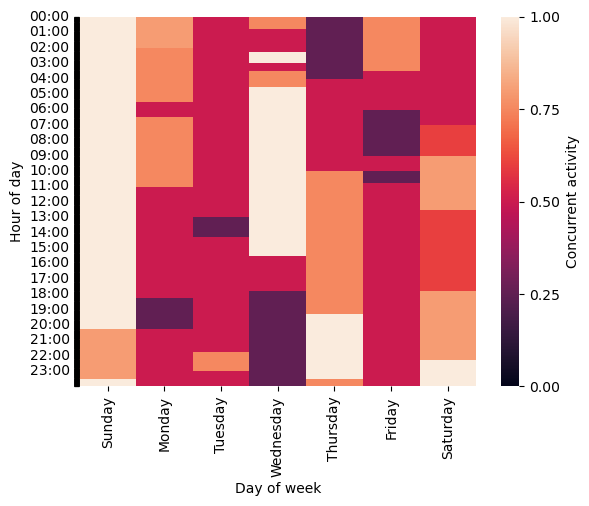

In [7]:
y_tick_labels = []
for h in range(0, 24):
    y_tick_labels.append(pd.to_datetime(f'{h}:00').strftime('%H:%M'))
    y_tick_labels.extend([None for x in range(0,59)])

graph = sn.heatmap(
    cc_activity_wa,
    yticklabels=y_tick_labels,
    vmin=0,
    vmax=1.0,
    cbar_kws={
        'label': 'Concurrent activity',
        'ticks': [0.0, 0.25, 0.5, 0.75, 1.0]
    })
plt.ylabel('Hour of day')
plt.xlabel('Day of week')
sn.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()